In [55]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pickle 

%matplotlib inline
plt.style.use('fivethirtyeight')

In [31]:
roman = pd.read_csv('./model_data_2.csv', index_col=0)
roman = roman.drop(list(roman.loc[(roman['current_price'] < 3)| 
                          (roman['current_price']> 1000)].index), axis=0).reset_index(drop=True)

roman = roman.drop('charityId', axis=1)

In [32]:
words = roman['URLTitle']

In [33]:
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def cleaner(title):
    """ This function accepts a string, removes any preceding number, removes stopwords,
    removes any non-alphanumeric, lemmatizes, and then return the words as a joined string"""
    title_2 = re.sub(r'^\d+', " ", title)
    tokenizer = RegexpTokenizer(r'\w+|\d+')
    no_chars = re.sub(r"[^a-zA-Z0-9]", " ", title_2)
    no_chars_2 = re.sub(r"\b0+[0-9]+|\b[a-z][0-9]+", "", no_chars)
    titles = tokenizer.tokenize(no_chars_2.lower())
    lst = [word for word in titles if word not in stop]
    lemons = [lemmatizer.lemmatize(word) for word in lst]
    final = ' '.join(lemons)
    return final

In [34]:
cleaned_words = words.apply(cleaner)

In [35]:
cvec = CountVectorizer()
cvec.fit(cleaned_words)
cvecdata = cvec.transform(cleaned_words)

In [36]:
feature_df = pd.DataFrame(cvecdata.todense(), 
                           columns=cvec.get_feature_names())

In [37]:
feature_df.T.sum(axis=1).sort_values(ascending=False).head(10)

coin           17381
roman          17188
ancient        12158
silver          3542
ad              3513
constantine     2587
bronze          2575
authentic       2530
empire          2288
great           2091
dtype: int64

In [38]:
tf_transformer = TfidfTransformer().fit(cvecdata)
#sublinear_tf=True
word_vector = tf_transformer.transform(cvecdata)

# BASIC LR MODEL with just the title_vector

In [39]:
X = word_vector
y = np.log(roman['current_price'].values)

In [40]:
def basic_linear_model(X, y, model, **kwargs):
    """basic linear model that takes in features and response variable,
    prints r-squared, graphs predicted vs. y-test, and returns predicted and actual
    test values"""
    lr = model(**kwargs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    lr.fit(X_train, y_train)
    print('The R-squared score: ', lr.score(X_test, y_test))
    preds = lr.predict(X_test)
    fig, ax = plt.subplots(figsize=(15,7))
    plt.scatter(np.arange(len(preds)), np.sort(preds), alpha=0.5, c='r', label='predictions')
    plt.scatter(np.arange(len(preds)), np.sort(y_test), alpha=0.5, c='g', label='true values')
    plt.legend().set_alpha(1)
    plt.show()
    return y_test, preds

The R-squared score:  0.4742043382480089


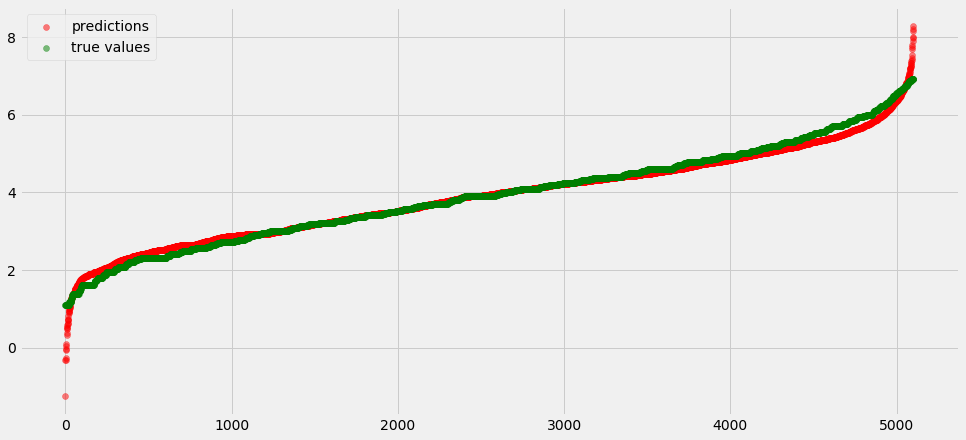

In [41]:
y_test, preds = basic_linear_model(X, y, LinearRegression)

In [43]:
def baseline_SSE(preds, y_test):
    """Prints the sum of squared errors for baseline and model and then gives the percentage
    improvement (or decline)"""
    baseline = np.array([y_test.mean() for x in range(len(y_test))])
    print('Sum of Squared Errors: ', np.sum((preds - y_test)**2))
    print('Baseline Error: ', np.sum((baseline - y_test)**2))
   

baseline_SSE(preds, y_test)

Sum of Squared Errors:  4214.850900937086
Baseline Error:  8016.138602005354


# Basic model with  dummies/time/demand features

In [44]:
roman = roman.drop(['URLTitle', 'itemId'], axis=1)

y = np.log(roman['current_price'].values)
X = roman.drop('current_price', axis=1)

The R-squared score:  0.569111085859952


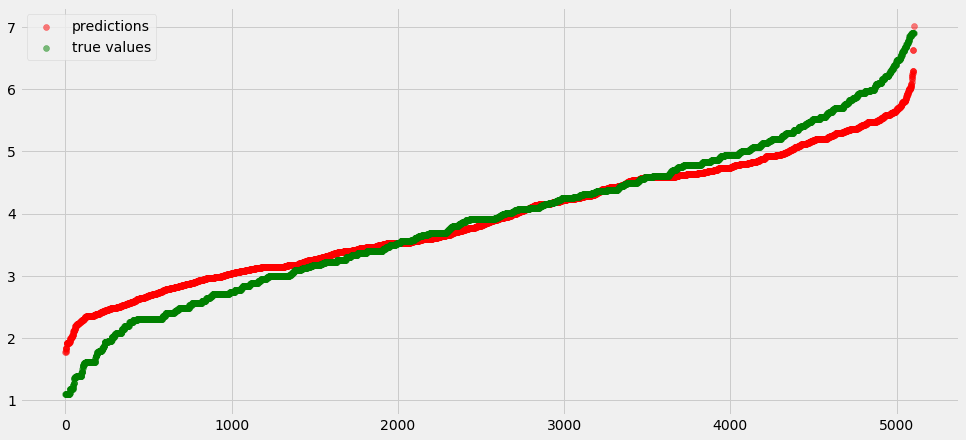

In [45]:
y_test, preds = basic_linear_model(X, y, LinearRegression)

In [46]:
baseline_SSE(preds, y_test)

Sum of Squared Errors:  3408.3622438755633
Baseline Error:  7910.071788868938


# Models using Random Forest Regressor

The R-squared score:  0.713388258655433


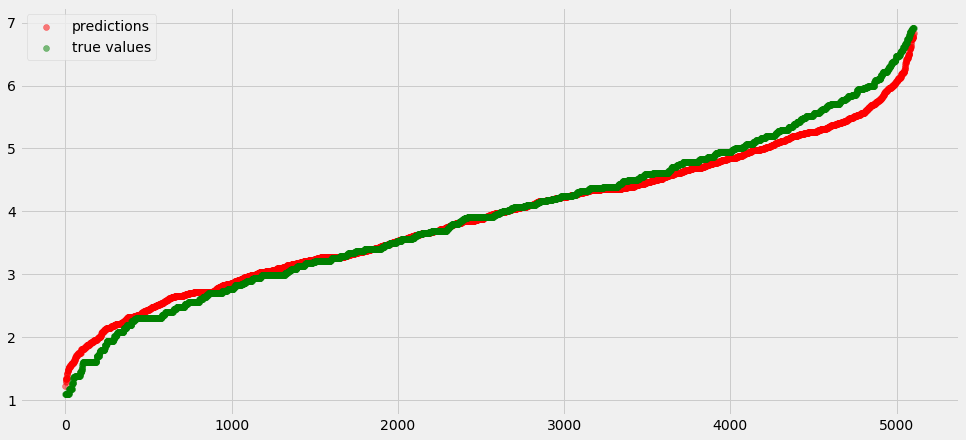

In [47]:
#FULL cleaned feature set 
y = np.log(roman['current_price'].values)
X = roman.drop('current_price', axis=1)

y_test, preds = basic_linear_model(X, y, RandomForestRegressor)

In [48]:
baseline_SSE(preds, y_test)

Sum of Squared Errors:  2286.6751753869457
Baseline Error:  7978.302510077163


The R-squared score:  0.6648038236475761


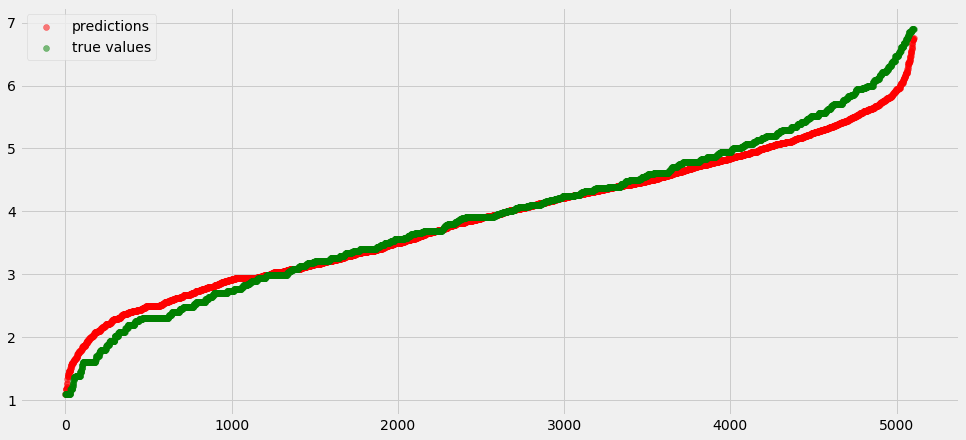

In [49]:
#MODEL using title vector

X = word_vector
y = np.log(roman['current_price'].values)

y_test, preds = basic_linear_model(X, y, RandomForestRegressor)

In [50]:
baseline_SSE(preds, y_test)

Sum of Squared Errors:  2696.1612303722713
Baseline Error:  8043.532177817977


# Dropping insignificant variables and adding quadratic/interaction terms

In [51]:
y = np.log(roman['current_price'].values)
X = roman.drop(['completed_no_time_left', 'less_than_hour_left', 'less_than_week_left', 'aemilian', 'antoninus pius',
'aurelian', 'balbinus', 'carinus', 'carus', 'claudius', 'constans i', 'decius', 'galba',
'gallienus', 'gordian i', 'jovian', 'leo i', 'licinius', 'numerian', 'tacitus', 'theodosius i',
'valerian', 'current_price', 'less_than_2day_left'], axis=1)

In [52]:
X['bidCountsq'] = X['bidCount'].values **2
X['bidCountcubed'] = X['bidCount'].values ** 3
X['interbidwatch'] = X['bidCount'] * X['watchCount']

The R-squared score:  0.7115816922780807


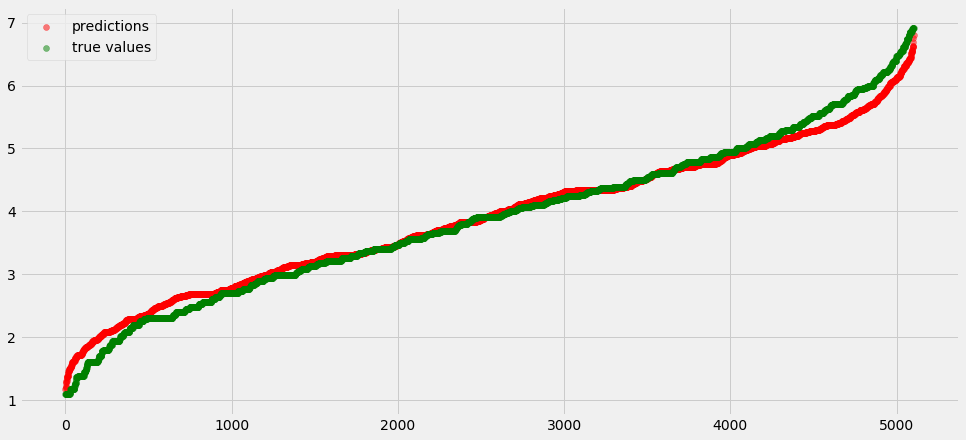

In [53]:
y_test, preds = basic_linear_model(X, y, RandomForestRegressor)

In [54]:
baseline_SSE(preds, y_test)

Sum of Squared Errors:  2366.5286692150576
Baseline Error:  8205.19573777114


# Hyperparameter tuning

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

param_grid = {"n_estimators": [200, 500],
    "max_depth": [3, None],
    "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False]}

model = RandomForestRegressor(random_state=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)

0.7226174193397531
{'bootstrap': False, 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [67]:
with open('./grid_search_roman.pickle', 'wb') as file_handle:
     pickle.dump(grid, file_handle, protocol=3)

The R-squared score:  0.7380262425070155


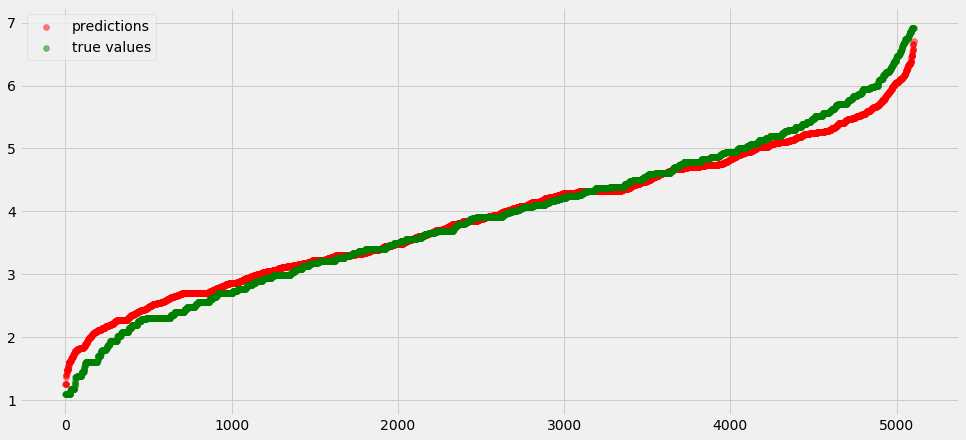

In [66]:
#Model to use
y_test, preds = basic_linear_model(X, y, RandomForestRegressor, bootstrap= False, max_depth=None, 
                                   max_features= 3, min_samples_leaf= 1, 
                                   min_samples_split= 5, n_estimators= 700)